# Exercise 6 - Conjoint Analysis

In this exercise you will work mostly on your own. You will have to reread in the lectures script and think about own measures of quality.

### Submission

- Deadline of submission:
        x.y.z
- Mail your solution notebook or a link to your gitlab repository (with the solution notebook inside) to:
        paul.kahlmeyer@uni-jena.de

In the event of a persistent problem, do not hesitate to contact the course instructors.

# The Dataset

In this exercise we will use preprocessed [statistics of Bundesliga clubs](https://www.whoscored.com/Regions/81/Tournaments/3/Seasons/6902/Stages/15243/TeamStatistics/Germany-Bundesliga-2017-2018) to predict their ranking in the table. Each dataset has the following attributes:

- `Team`: team name
- `Shots pg`: average shots on opponent goal per game
- `Yellow cards`: number of yellow cards
- `Red cards`: number of red cards
- `Possession%`: average ball possession percentage per game
- `Pass%`: average percentage of sucessful passes
- `AerialsWon`: average number of aerial duels won per game
- `Rank`: rank in the table

Each of these attributes was discretized into 3 categories based on the range of values for the season:

- 0: lower third of season range
- 1: central third of season range
- 2: upper third of season range

### Task 1

Load and inspect the dataset for the season 2017/2018 stored in `buli_1718.csv`.

In [1]:
# TODO: load season 2017/2018 dataset
import pandas as pd
df = pd.read_csv('buli_1718.csv')
df.head()

,Team,Shots pg,Yellow cards,Red cards,Possession%,Pass%,AerialsWon,Rank
0,Bayern Munich,2,0,0,2,2,0,1
1,Freiburg,0,0,2,0,0,2,15
2,VfB Stuttgart,0,1,0,0,0,1,7
3,Borussia M.Gladbach,1,0,0,1,1,0,9
4,Hoffenheim,1,2,0,0,1,0,3


In conjoint analysis the dataset has to be a series of choice tasks
\begin{equation}
((a^{(i)},b^{(i)}),y^{(i)})\,,
\end{equation}
where $y^{(i)}=1$, if $a$ has been chosen and $-1$ otherwise.

We can transform our dataset into choice tasks if we consider $a$ and $b$ as the properties of teams and choose the team with the higher ranking. Of course $a$ and $b$ are **not** containing the ranking themselves.

### Task 2

Translate the dataset into a set of choice tasks.

In [2]:
# Translate into dataset ((a,b),y)
import numpy as np

rankings = np.array(df['Rank'])
items = np.stack([np.array(df[k]) for k in df.keys()[1:-1]]).T
nmb_cats = 3

options = []
choices = []
for i, (a, ranking_a) in enumerate(zip(items, rankings)):
    for j, (b, ranking_b) in enumerate(zip(items, rankings)):
        if i<j:
            if ranking_a<ranking_b:
                y = 1
            else:
                y = -1
            options.append((a,b))
            choices.append(y)

In order to exploit the duality of points and planes, we have to translate the options $a$ and $b$ into the plane
\begin{equation}
n^{(i)} = \mathbb{1}_{a^{(i)}}-\mathbb{1}_{b^{(i)}}
\end{equation}

### Task 3
Reread in the lecture script, how $\mathbb{1}_{a^{(i)}}$ is defined. 
Implement a function `vec`, that transforms $a$ into $\mathbb{1}_{a^{(i)}}$.

In [3]:
def vec(a):
    # TODO: translate item into vectorized form
    ret = []
    for i, c in enumerate(a):
        tmp = np.zeros(nmb_cats)
        tmp[c] = 1
        ret.append(tmp)
    return np.concatenate(ret)

### Task 4
Now use `vec` to translate $((a^{(i)},b^{(i)}),y^{(i)})$ into $(n^{(i)},y^{(i)})$

In [4]:
# TODO: translate options into planes
planes = np.stack([vec(a)-vec(b) for a,b in options])

# Estimation of partworth vector

Now we have a set of labeled hyperplanes and are looking for a value function, that can predict which hyperplane we choose. Our main assumption is, that this function is based on a vector of partworths $v$.

### Task 5
Reread in the script, how the value function is defined and implement a version `value`, that takes an item $a$ from the dataset and a partworth vector $v$ as input and outputs the value of $a$.

In [5]:
def value(a, v):
    # TODO: implement value function
    return np.sum(vec(a)*v)

Thanks to the duality of hyperplanes and points, we can interpret the hyperplanes $n^{(i)}$ as points and the partworth vector $v$ as a hyperplane. With this view, our problem of estimating $v$ reduces to a simple binary classification task.

### Task 6

Estimate $v$ using any binary classificator you like. Read in the script, if there are special constraints to the classifier.

In [25]:
# TODO: use binary classificator
from sklearn.linear_model import SGDClassifier
regressor =  SGDClassifier(fit_intercept=False, alpha=2e-2, random_state=0)
regressor.fit(planes, choices)
v = regressor.coef_.flatten()

### Task 7
Implement a `predict` function, that takes two items and the partworth vector and outputs -1 or 1.

Test this function on the dataset and determine the accuracy. Tune your classifier to get a high accuracy.

In [33]:
def predict(a,b, v):
    # TODO: predict 1 or -1
    v_a = value(a, v)
    v_b = value(b, v)
    return 2*(v_a>v_b)-1
    
# TODO: determine accuracy
preds = np.array([predict(a,b,v) for a,b in options])
test_acc = np.mean(choices == preds)
print(f'Accuracy: {test_acc}')

Accuracy: 0.8104575163398693


The estimated partworth vector contains information on the importance of the features on the table rank.

As an example, there are three entries in $v$, that correspond to `shots pg` being below average, average or above average in the season. We would expect above average to have the highest value among these three, because teams with more shots per game tend to score more goals and win more games.

### Task 8 
Visualize the information contained in the partworth vector. How do you interpret this information? Is everything as you would expect?

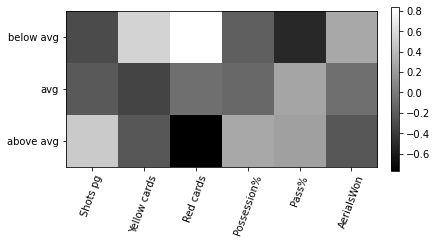

In [34]:
# TODO: visualize priorities set by v
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.imshow(v.reshape(6,nmb_cats).T, cmap='gray')
plt.xticks(ticks = np.arange(0,items.shape[1],1), labels = df.keys()[1:-1], rotation=70)
plt.yticks(ticks = np.arange(0,nmb_cats,1), labels = ['below avg', 'avg', 'above avg'])
plt.colorbar(fraction=0.03, pad=0.04)

# Prediction of table ranking

Besides getting an inside into the effect of certain attributes, we can also use the partworth vector to predict the ranking of other items.

### Task 9

Load the dataset for the season 2018/2019 stored in `buli_1819.csv`.

In [35]:
# TODO: load season 2018/2019 dataset
df = pd.read_csv('buli_1819.csv')
df.head()

,Team,Shots pg,Yellow cards,Red cards,Possession%,Pass%,AerialsWon,Rank
0,Wolfsburg,0,2,0,1,1,1,6
1,Bayern Munich,2,0,1,2,2,0,1
2,Schalke 04,0,2,2,0,0,1,14
3,Hannover 96,0,1,2,0,0,1,17
4,Borussia M.Gladbach,1,0,0,1,2,0,5


### Task 10

Print the table that you would predict with the partworth vector we estimated from the season 2018/2019.

Hint: If Bayern is somewhere on top and Nürnberg somewhere on the bottom, its a good rating ^^

In [37]:
# TODO: print predicted table
items = np.stack([np.array(df[k]) for k in df.keys()[1:-1]]).T
est_ranking = np.argsort([-value(x, v) for x in items])
df[:].loc[est_ranking]

,Team,Shots pg,Yellow cards,Red cards,Possession%,Pass%,AerialsWon,Rank
12,Bayer Leverkusen,1,0,0,2,2,0,4
1,Bayern Munich,2,0,1,2,2,0,1
4,Borussia M.Gladbach,1,0,0,1,2,0,5
11,Borussia Dortmund,0,0,1,2,2,0,2
13,Hoffenheim,2,2,1,1,1,0,9
0,Wolfsburg,0,2,0,1,1,1,6
9,Freiburg,0,1,1,0,1,0,13
7,Fortuna Duesseldorf,0,2,0,0,0,1,10
8,Mainz 05,1,1,0,0,0,1,12
17,Augsburg,1,1,0,0,0,1,15


We saw, that $v$ implies an order (ranking) among the items, which results in a table prediction.

### Task 11

Define some measure of quality to quantify or good the prediction of the table is compared to the true ranking in the table.

In [32]:
# TODO: quantify quality of predicted ranking compared to true ranking
def rank(X):
    ranks = np.zeros(X.shape[0])
    sort_idx = np.argsort([-value(a, v) for a in X])
    for ranking, item_idx in enumerate(sort_idx):
        ranks[item_idx] = ranking+1
    return ranks.astype(np.uint8)


rankings = np.array(df['Rank'])
measure = np.mean(abs(rankings-rank(items)))
print(f'Median distance to true rank: {measure}')

Median distance to true rank: 3.0


# Create Dataset (Just for me)

## Bundesliga

In [752]:
import pandas as pd
season = '1920'
filename = f'buli{season}.txt'
df = pd.read_csv(filename)
df = df.drop(columns=['Goals'])
df.head()

,Team,Shots pg,Yellow cards,Red cards,Possession%,Pass%,AerialsWon,Rank
0,Bayern Munich,18.1,50,3,61.5,86.9,14.4,1
1,Borussia Dortmund,13.1,47,1,58.5,86.9,11.0,2
2,RB Leipzig,16.2,47,3,54.1,82.6,15.5,3
3,Borussia M.Gladbach,14.1,71,3,51.7,81.8,16.7,4
4,Bayer Leverkusen,14.5,55,6,60.1,85.1,15.6,5


In [753]:
col_names = ['Shots pg', 'Yellow cards', 'Red cards', 'Possession%', 'Pass%', 'AerialsWon']
parts = 3
for col_name in col_names:
    min_v = np.min(df[col_name])
    max_v = np.max(df[col_name])
    ks = np.linspace(min_v,max_v,parts+1)
    ks[0] -= 1
    ks[-1] += 1
    print(ks)
    for i in range(len(ks)-1):
        l = ks[i]
        u = ks[i+1]
        
        mask = np.array(df[col_name]>l) & np.array(df[col_name]<=u)
        df[col_name][mask] = i
    
    df[col_name] = df[col_name].astype(np.uint8)

[ 9.6 13.1 15.6 19.1]
[40. 54. 67. 81.]
[-1.  2.  4.  7.]
[40.3        48.03333333 54.76666667 62.5       ]
[68.8 75.5 81.2 87.9]
[10.  16.4 21.8 28.2]


<ipython-input-753-94bf382a95e9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name][mask] = i
<ipython-input-753-94bf382a95e9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name][mask] = i
<ipython-input-753-94bf382a95e9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name][mask] = i
<ipython-input-753-94bf382a95e9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [754]:
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv(f'buli_{season}.csv', index=False)
df.head()

,Team,Shots pg,Yellow cards,Red cards,Possession%,Pass%,AerialsWon,Rank
0,FC Koln,0,2,1,0,1,1,14
1,Bayer Leverkusen,1,1,2,2,2,0,5
2,Eintracht Frankfurt,1,2,1,1,1,1,9
3,Freiburg,1,0,0,1,1,1,8
4,Hoffenheim,1,1,0,1,2,1,6


## Synthetic

In [167]:
import numpy as np
import pickle

def draw_item(n, nlevels):
    return [np.random.randint(0,nlevels) for _ in range(n)]

def v(a, vs):
    return np.sum(np.diag(vs[:,a]))

def compare(a,b, vs):
    v_a = v(a, vs)
    v_b = v(b, vs)
    if v_a > v_b:
        return 1
    else:
        return -1
    
def save_data(data, path):

    pickle.dump(data, open( path, 'wb' ))

def load_data(path):
    return pickle.load(open( path, 'rb') )

In [168]:
np.random.seed(1)
n = 5 # number of attributes
nlevels = 3 # number of levels for each attribute
vs = np.array([np.random.rand(nlevels) for _ in range(n)]) # true partworths

# Generate data
N = 10
data = []
for _ in range(N):
    a = draw_item(n, nlevels)
    b = draw_item(n, nlevels)
    y = compare(a,b,vs)
    data.append((a,b,y))
    
# Save data
save_data(data, 'data.p')